In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn

from tqdm import tqdm

from Data import load_df, ChannelJitter, RandomNoise
from Network import Unet, ssim_loss, ConvolutionBlock, ASPP

path = "datasets/" + "with_labels/"
device = "cuda"

IM = torch.tensor([ 0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5, 0.0]).to(device)

IS = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5, 1.0]).to(device)

df = load_df(path)
df_z = df[df["mean"] < 0.2].sample(frac=0.1)
df = pd.concat([df[df["mean"] >= 0.2], df_z])

df.head()

,lat,lon,year,month,day,mean,filename
5,-3.95,-54.78,2021,5,1,0.94,Labeled_-3.95_-54.78_2021_05_01_0.94.npy
7,-4.03,-54.72,2020,8,1,0.46,Labeled_-4.03_-54.72_2020_08_01_0.46.npy
9,-3.47,-54.78,2018,6,1,0.58,Labeled_-3.47_-54.78_2018_06_01_0.58.npy
11,-4.19,-54.98,2020,8,1,0.74,Labeled_-4.19_-54.98_2020_08_01_0.74.npy
13,-3.77,-54.76,2019,8,1,0.32,Labeled_-3.77_-54.76_2019_08_01_0.32.npy


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df, validaion=False):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        if validaion:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                #transforms.CenterCrop((64, 64)),
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                
                transforms.RandomApply([transforms.RandomRotation(360, interpolation=transforms.InterpolationMode.BILINEAR)], p=0.5),
                
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
                
                transforms.RandomApply([ChannelJitter(0.2, 0.2)], p=0.2),
                transforms.RandomApply([RandomNoise(0.2)], p=0.2),
            ])

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]

        img = np.load(self.img_dir + filename)
        img = self.transform(img)

        return img[:-1, :, :].to(device), img[-1, :, :].to(device)

# Results depend on validation set, so we fix the seed
np.random.seed(0)
torch.manual_seed(0)

positions = df[["lat", "lon"]].drop_duplicates()

train_positions = positions.sample(frac=0.8)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df, validaion=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds) * 4, shuffle=True)

test_dl = DataLoader(train_ds, batch_size=len(val_ds), shuffle=True)

len(train_ds), len(val_ds)

val_ds.positions

,lat,lon
31,-3.43,-54.90
65,-4.05,-54.92
68,-4.07,-55.04
70,-4.05,-54.62
77,-3.47,-54.66
...,...,...
16893,-3.85,-55.16
232,-3.69,-54.64
10420,-3.49,-55.00
16115,-3.33,-54.58


In [3]:
im, lb = next(iter(val_dl))
print(im.mean(dim=[0,2,3]))
print(im.std(dim=[0,2,3]))

tensor([-1.7294e-01, -1.5046e-01, -5.1527e-01, -9.3463e-02, -2.3735e-01,
         8.0097e-02,  1.2104e-01,  5.1860e-01, -1.7943e-01, -1.5752e-01,
        -5.2596e-01, -1.0298e-01, -2.6849e-01,  4.3124e-02,  9.6545e-02,
         5.3899e-01, -1.9531e-01, -1.7890e-01, -5.6118e-01, -1.3272e-01,
        -3.3095e-01,  2.8669e-04,  4.6467e-02,  6.5725e-01], device='cuda:0')
tensor([0.4979, 0.5099, 0.5074, 0.5325, 1.0769, 0.9807, 0.8273, 0.8550, 0.4914,
        0.5051, 0.5049, 0.5269, 1.1106, 0.9706, 0.8118, 0.8423, 0.4566, 0.4674,
        0.4629, 0.4820, 0.9668, 0.8658, 0.7115, 0.7537], device='cuda:0')


In [4]:
#https://www.mdpi.com/2079-9292/11/1/130
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            ConvolutionBlock(8, 8, kernel_size=3),
            ASPP(8, 8),
        )

        self.unet = Unet(8 * 3, 16, attention=True)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            #nn.Sigmoid() # Sigmoid is included in the loss
        )

    def forward(self, x):

        # x shape is (batch, 24, 64, 64)

        # Divide the second channel in x0, x1 and x2
        x0, x1, x2 = torch.split(x, 8, dim=1)
        x0 = self.enc(x0)
        x1 = self.enc(x1)
        x2 = self.enc(x2)

        # Concatenate the three channels
        x = torch.cat([x0, x1, x2], dim=1)

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x *= 1000000

        return x

model = Network().to(device)

In [5]:
@torch.no_grad()
def plot_images():
    im, lb = next(iter(val_dl))
    lb = lb[:, None, ...]
    out = torch.sigmoid(model(im))

    im0 = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
    im0 = im0.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im1 = (im[0][11:14] * IS[11:14, None, None]) + IM[11:14, None, None]
    im1 = im1.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im2 = (im[0][19:22] * IS[19:22, None, None]) + IM[19:22, None, None]
    im2 = im2.permute(1, 2, 0).clip(0,1).cpu().numpy()

    label = lb[0][0].cpu().numpy()
    output = out[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(15, 10))
    axes[0].imshow(im0)
    axes[1].imshow(im1)
    axes[2].imshow(im2)
    axes[3].imshow(label, vmin=0, vmax=1)
    axes[4].imshow(output, vmin=0, vmax=1)
    plt.show()

In [6]:
@torch.no_grad()
def f1_score(dl):
    im, lb = next(iter(dl))

    label = lb[:, None, ...]
    output = torch.sigmoid(model(im))

    tp = torch.sum(output * label)
    fp = torch.sum(output * (1-label))
    fn = torch.sum((1-output) * label)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    
    union = tp + fp + fn
    iou = tp / union # recall / (recall + 1) ?

    return float(f1), float(iou)

In [7]:
model.train()

bce_loss = nn.BCEWithLogitsLoss()
loss_fn = lambda output, target: bce_loss(output, target) + 2 * ssim_loss(torch.sigmoid(output), target)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 300
patience = 100

best_f1 = -torch.inf
best_model = model.state_dict()

val_losses = []
train_losses = []

model.train()
for i in range(epochs):

    # Train
    pbar = tqdm(train_dl)#, miniters=5)
    for data in pbar:
        optimizer.zero_grad()

        im, lb = data
        lb = lb[:, None, ...]

        out = model(im)
        loss = loss_fn(out, lb).mean()
        pbar.set_description(f"Epoch {i}. Loss: {loss:.4f}", refresh=False)
        
        loss.backward()
        optimizer.step()
    
    # Eval
    with torch.no_grad():
        model.eval()

        f1, iou = f1_score(val_dl)
        val_losses.append((f1, iou))

        if best_f1 < f1:
            best_f1 = f1
            best_model = model.state_dict()
            pat_count = 0
            print(f'{f1:.5f} *')
        else:
            print(f'{f1:.5f}')

        f1, iou = f1_score(test_dl)
        train_losses.append((f1, iou))

        pat_count = pat_count + 1
        if pat_count == patience:
            model.load_state_dict(best_model)
            print("Patience ended.")
            break

        model.train()

Epoch 0. Loss: 1.5984: 100%|██████████| 64/64 [00:11<00:00,  5.50it/s]


0.48272 *


Epoch 1. Loss: 1.3400: 100%|██████████| 64/64 [00:05<00:00, 11.78it/s]


0.67811 *


Epoch 2. Loss: 1.3856: 100%|██████████| 64/64 [00:04<00:00, 13.86it/s]


0.67481


Epoch 3. Loss: 1.3172: 100%|██████████| 64/64 [00:04<00:00, 14.93it/s]


0.74409 *


Epoch 4. Loss: 1.2560: 100%|██████████| 64/64 [00:04<00:00, 14.80it/s]


0.71988


Epoch 5. Loss: 1.3922: 100%|██████████| 64/64 [00:04<00:00, 14.49it/s]


0.75922 *


Epoch 6. Loss: 1.1291: 100%|██████████| 64/64 [00:04<00:00, 15.32it/s]


0.76672 *


Epoch 7. Loss: 1.2338: 100%|██████████| 64/64 [00:04<00:00, 15.56it/s]


0.75662


Epoch 8. Loss: 1.1646: 100%|██████████| 64/64 [00:03<00:00, 16.04it/s]


0.79193 *


Epoch 9. Loss: 1.0576: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.78604


Epoch 10. Loss: 1.2837: 100%|██████████| 64/64 [00:03<00:00, 16.23it/s]


0.81112 *


Epoch 11. Loss: 0.9510: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.80929


Epoch 12. Loss: 1.4692: 100%|██████████| 64/64 [00:03<00:00, 17.10it/s]


0.80274


Epoch 13. Loss: 1.2558: 100%|██████████| 64/64 [00:04<00:00, 15.88it/s]


0.81423 *


Epoch 14. Loss: 1.0980: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.80815


Epoch 15. Loss: 1.0499: 100%|██████████| 64/64 [00:03<00:00, 17.08it/s]


0.80656


Epoch 16. Loss: 1.1119: 100%|██████████| 64/64 [00:03<00:00, 17.07it/s]


0.81827 *


Epoch 17. Loss: 1.1244: 100%|██████████| 64/64 [00:03<00:00, 17.33it/s]


0.82569 *


Epoch 18. Loss: 1.1165: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.81997


Epoch 19. Loss: 1.0551: 100%|██████████| 64/64 [00:03<00:00, 16.99it/s]


0.80867


Epoch 20. Loss: 0.9967: 100%|██████████| 64/64 [00:03<00:00, 17.18it/s]


0.82923 *


Epoch 21. Loss: 1.2854: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.81929


Epoch 22. Loss: 0.9853: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.81738


Epoch 23. Loss: 0.9340: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.81301


Epoch 24. Loss: 1.0643: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.82510


Epoch 25. Loss: 1.1803: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.82617


Epoch 26. Loss: 1.1042: 100%|██████████| 64/64 [00:03<00:00, 17.20it/s]


0.82019


Epoch 27. Loss: 1.0258: 100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


0.83066 *


Epoch 28. Loss: 1.1413: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.81684


Epoch 29. Loss: 1.0005: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.83934 *


Epoch 30. Loss: 1.1097: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.82188


Epoch 31. Loss: 1.0021: 100%|██████████| 64/64 [00:03<00:00, 17.04it/s]


0.81998


Epoch 32. Loss: 1.0651: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.83476


Epoch 33. Loss: 0.9596: 100%|██████████| 64/64 [00:03<00:00, 16.99it/s]


0.82856


Epoch 34. Loss: 0.9229: 100%|██████████| 64/64 [00:03<00:00, 17.33it/s]


0.83093


Epoch 35. Loss: 1.1854: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.82795


Epoch 36. Loss: 1.0324: 100%|██████████| 64/64 [00:03<00:00, 17.12it/s]


0.83889


Epoch 37. Loss: 1.0275: 100%|██████████| 64/64 [00:03<00:00, 17.13it/s]


0.84177 *


Epoch 38. Loss: 0.8954: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.83763


Epoch 39. Loss: 0.9850: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.83909


Epoch 40. Loss: 1.0990: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.83741


Epoch 41. Loss: 0.8768: 100%|██████████| 64/64 [00:03<00:00, 17.37it/s]


0.83558


Epoch 42. Loss: 0.9386: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.83983


Epoch 43. Loss: 0.8386: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.84585 *


Epoch 44. Loss: 1.1380: 100%|██████████| 64/64 [00:03<00:00, 17.00it/s]


0.84364


Epoch 45. Loss: 1.0774: 100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


0.83210


Epoch 46. Loss: 1.2874: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.81919


Epoch 47. Loss: 0.8665: 100%|██████████| 64/64 [00:03<00:00, 17.15it/s]


0.83620


Epoch 48. Loss: 1.1113: 100%|██████████| 64/64 [00:03<00:00, 17.07it/s]


0.85036 *


Epoch 49. Loss: 0.9654: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.84859


Epoch 50. Loss: 1.0066: 100%|██████████| 64/64 [00:03<00:00, 17.06it/s]


0.84540


Epoch 51. Loss: 1.1107: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.84615


Epoch 52. Loss: 1.0937: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.84644


Epoch 53. Loss: 0.9380: 100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


0.85157 *


Epoch 54. Loss: 1.0410: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.85130


Epoch 55. Loss: 1.0710: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.84185


Epoch 56. Loss: 0.9656: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.84323


Epoch 57. Loss: 1.1933: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.85370 *


Epoch 58. Loss: 0.8189: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.84745


Epoch 59. Loss: 1.1605: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.84500


Epoch 60. Loss: 0.9947: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.83866


Epoch 61. Loss: 0.9987: 100%|██████████| 64/64 [00:03<00:00, 17.15it/s]


0.83587


Epoch 62. Loss: 1.0294: 100%|██████████| 64/64 [00:03<00:00, 17.20it/s]


0.84842


Epoch 63. Loss: 0.9983: 100%|██████████| 64/64 [00:03<00:00, 17.17it/s]


0.85233


Epoch 64. Loss: 0.8407: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.84804


Epoch 65. Loss: 0.9176: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.85106


Epoch 66. Loss: 1.0481: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.84387


Epoch 67. Loss: 0.7648: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.84663


Epoch 68. Loss: 1.0702: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.85622 *


Epoch 69. Loss: 0.9719: 100%|██████████| 64/64 [00:03<00:00, 16.92it/s]


0.85227


Epoch 70. Loss: 1.0163: 100%|██████████| 64/64 [00:03<00:00, 17.34it/s]


0.84139


Epoch 71. Loss: 1.0503: 100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


0.85013


Epoch 72. Loss: 1.1022: 100%|██████████| 64/64 [00:03<00:00, 17.20it/s]


0.85540


Epoch 73. Loss: 0.9779: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.85004


Epoch 74. Loss: 0.9830: 100%|██████████| 64/64 [00:03<00:00, 17.07it/s]


0.85090


Epoch 75. Loss: 0.9876: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.83673


Epoch 76. Loss: 1.0442: 100%|██████████| 64/64 [00:03<00:00, 16.95it/s]


0.84070


Epoch 77. Loss: 1.0109: 100%|██████████| 64/64 [00:03<00:00, 16.99it/s]


0.84724


Epoch 78. Loss: 0.9573: 100%|██████████| 64/64 [00:03<00:00, 17.20it/s]


0.84919


Epoch 79. Loss: 1.0350: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.85163


Epoch 80. Loss: 0.9048: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.84699


Epoch 81. Loss: 0.9497: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.85020


Epoch 82. Loss: 0.8122: 100%|██████████| 64/64 [00:03<00:00, 16.70it/s]


0.84871


Epoch 83. Loss: 1.0149: 100%|██████████| 64/64 [00:03<00:00, 17.05it/s]


0.85360


Epoch 84. Loss: 1.1390: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.84034


Epoch 85. Loss: 0.8299: 100%|██████████| 64/64 [00:03<00:00, 17.20it/s]


0.85881 *


Epoch 86. Loss: 0.8937: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.85413


Epoch 87. Loss: 0.7635: 100%|██████████| 64/64 [00:03<00:00, 17.41it/s]


0.85431


Epoch 88. Loss: 0.8258: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.84743


Epoch 89. Loss: 0.8094: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.84951


Epoch 90. Loss: 0.8192: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.85573


Epoch 91. Loss: 0.9252: 100%|██████████| 64/64 [00:03<00:00, 17.17it/s]


0.84981


Epoch 92. Loss: 0.9175: 100%|██████████| 64/64 [00:03<00:00, 17.09it/s]


0.84924


Epoch 93. Loss: 0.9276: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.85263


Epoch 94. Loss: 0.9062: 100%|██████████| 64/64 [00:03<00:00, 17.01it/s]


0.84778


Epoch 95. Loss: 0.8169: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.85040


Epoch 96. Loss: 0.8702: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.85518


Epoch 97. Loss: 1.0380: 100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


0.85321


Epoch 98. Loss: 0.8248: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.85268


Epoch 99. Loss: 0.8565: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.85407


Epoch 100. Loss: 0.9127: 100%|██████████| 64/64 [00:03<00:00, 17.02it/s]


0.85689


Epoch 101. Loss: 1.0179: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.85848


Epoch 102. Loss: 0.7294: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.85123


Epoch 103. Loss: 0.7580: 100%|██████████| 64/64 [00:03<00:00, 17.15it/s]


0.85484


Epoch 104. Loss: 1.0399: 100%|██████████| 64/64 [00:03<00:00, 17.15it/s]


0.84966


Epoch 105. Loss: 0.8952: 100%|██████████| 64/64 [00:03<00:00, 17.10it/s]


0.84992


Epoch 106. Loss: 0.9276: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.84992


Epoch 107. Loss: 0.9082: 100%|██████████| 64/64 [00:03<00:00, 16.86it/s]


0.85711


Epoch 108. Loss: 0.8559: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.84785


Epoch 109. Loss: 1.0120: 100%|██████████| 64/64 [00:03<00:00, 17.17it/s]


0.85421


Epoch 110. Loss: 0.9000: 100%|██████████| 64/64 [00:03<00:00, 17.17it/s]


0.84155


Epoch 111. Loss: 0.6560: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.85127


Epoch 112. Loss: 0.7912: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.84349


Epoch 113. Loss: 0.9483: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.84806


Epoch 114. Loss: 0.7432: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.85878


Epoch 115. Loss: 0.7546: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.85330


Epoch 116. Loss: 1.1229: 100%|██████████| 64/64 [00:03<00:00, 17.18it/s]


0.84657


Epoch 117. Loss: 0.8651: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.85247


Epoch 118. Loss: 0.8382: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.86216 *


Epoch 119. Loss: 0.8978: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.85505


Epoch 120. Loss: 0.8146: 100%|██████████| 64/64 [00:03<00:00, 17.00it/s]


0.86028


Epoch 121. Loss: 0.7173: 100%|██████████| 64/64 [00:03<00:00, 17.18it/s]


0.85309


Epoch 122. Loss: 0.9929: 100%|██████████| 64/64 [00:03<00:00, 17.20it/s]


0.85679


Epoch 123. Loss: 0.7379: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.86080


Epoch 124. Loss: 1.1183: 100%|██████████| 64/64 [00:03<00:00, 17.10it/s]


0.85498


Epoch 125. Loss: 0.6798: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.85774


Epoch 126. Loss: 0.8689: 100%|██████████| 64/64 [00:03<00:00, 17.05it/s]


0.86239 *


Epoch 127. Loss: 0.9230: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.84955


Epoch 128. Loss: 0.7770: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.85378


Epoch 129. Loss: 0.9805: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.86047


Epoch 130. Loss: 1.0550: 100%|██████████| 64/64 [00:03<00:00, 17.15it/s]


0.86246 *


Epoch 131. Loss: 0.9807: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.85483


Epoch 132. Loss: 0.7044: 100%|██████████| 64/64 [00:03<00:00, 16.98it/s]


0.85739


Epoch 133. Loss: 0.9623: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.85228


Epoch 134. Loss: 0.8847: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.84639


Epoch 135. Loss: 0.7354: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.84896


Epoch 136. Loss: 0.6602: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.85584


Epoch 137. Loss: 0.7910: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.85288


Epoch 138. Loss: 0.8087: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.85923


Epoch 139. Loss: 0.8053: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.85625


Epoch 140. Loss: 0.9348: 100%|██████████| 64/64 [00:03<00:00, 17.13it/s]


0.85548


Epoch 141. Loss: 0.8361: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.85210


Epoch 142. Loss: 0.8575: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.85286


Epoch 143. Loss: 0.7441: 100%|██████████| 64/64 [00:03<00:00, 17.13it/s]


0.85600


Epoch 144. Loss: 0.9451: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.86647 *


Epoch 145. Loss: 0.7801: 100%|██████████| 64/64 [00:03<00:00, 17.09it/s]


0.85727


Epoch 146. Loss: 0.7931: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.85555


Epoch 147. Loss: 0.7462: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.85869


Epoch 148. Loss: 0.8499: 100%|██████████| 64/64 [00:03<00:00, 17.18it/s]


0.86261


Epoch 149. Loss: 0.8548: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.85675


Epoch 150. Loss: 0.7934: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.85308


Epoch 151. Loss: 0.9164: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.85078


Epoch 152. Loss: 0.8105: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.86557


Epoch 153. Loss: 0.7404: 100%|██████████| 64/64 [00:03<00:00, 17.12it/s]


0.85469


Epoch 154. Loss: 0.9808: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.85541


Epoch 155. Loss: 0.9071: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.85621


Epoch 156. Loss: 0.8108: 100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


0.85387


Epoch 157. Loss: 0.7411: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.86102


Epoch 158. Loss: 0.9325: 100%|██████████| 64/64 [00:03<00:00, 16.93it/s]


0.85335


Epoch 159. Loss: 0.6525: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.84772


Epoch 160. Loss: 0.6818: 100%|██████████| 64/64 [00:03<00:00, 17.15it/s]


0.86468


Epoch 161. Loss: 0.8277: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.85012


Epoch 162. Loss: 0.8485: 100%|██████████| 64/64 [00:03<00:00, 17.35it/s]


0.85601


Epoch 163. Loss: 0.8315: 100%|██████████| 64/64 [00:03<00:00, 17.05it/s]


0.85824


Epoch 164. Loss: 0.7553: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.85778


Epoch 165. Loss: 0.9887: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.86563


Epoch 166. Loss: 0.9598: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.85378


Epoch 167. Loss: 0.9964: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.86112


Epoch 168. Loss: 0.5317: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.86576


Epoch 169. Loss: 0.7012: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.85864


Epoch 170. Loss: 0.9000: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.84942


Epoch 171. Loss: 0.7905: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.84981


Epoch 172. Loss: 0.7364: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.86219


Epoch 173. Loss: 0.8036: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.85596


Epoch 174. Loss: 0.8405: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.86714 *


Epoch 175. Loss: 0.9196: 100%|██████████| 64/64 [00:03<00:00, 17.17it/s]


0.86055


Epoch 176. Loss: 0.7850: 100%|██████████| 64/64 [00:03<00:00, 17.09it/s]


0.85356


Epoch 177. Loss: 0.9822: 100%|██████████| 64/64 [00:03<00:00, 17.34it/s]


0.86099


Epoch 178. Loss: 0.7039: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.85701


Epoch 179. Loss: 0.6876: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.85477


Epoch 180. Loss: 0.6918: 100%|██████████| 64/64 [00:03<00:00, 17.38it/s]


0.85651


Epoch 181. Loss: 0.7059: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.86003


Epoch 182. Loss: 0.7606: 100%|██████████| 64/64 [00:03<00:00, 17.35it/s]


0.85663


Epoch 183. Loss: 0.9718: 100%|██████████| 64/64 [00:03<00:00, 16.92it/s]


0.86470


Epoch 184. Loss: 0.6288: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.85126


Epoch 185. Loss: 0.6494: 100%|██████████| 64/64 [00:03<00:00, 17.38it/s]


0.86857 *


Epoch 186. Loss: 0.7674: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.86040


Epoch 187. Loss: 0.8082: 100%|██████████| 64/64 [00:03<00:00, 17.35it/s]


0.86041


Epoch 188. Loss: 0.7668: 100%|██████████| 64/64 [00:03<00:00, 17.07it/s]


0.86067


Epoch 189. Loss: 0.8866: 100%|██████████| 64/64 [00:03<00:00, 17.13it/s]


0.85529


Epoch 190. Loss: 0.7463: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.85685


Epoch 191. Loss: 0.8526: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.85652


Epoch 192. Loss: 0.7976: 100%|██████████| 64/64 [00:03<00:00, 17.33it/s]


0.85511


Epoch 193. Loss: 0.7519: 100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


0.86242


Epoch 194. Loss: 0.8690: 100%|██████████| 64/64 [00:03<00:00, 17.15it/s]


0.85728


Epoch 195. Loss: 0.8370: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.85558


Epoch 196. Loss: 0.9270: 100%|██████████| 64/64 [00:03<00:00, 16.98it/s]


0.85554


Epoch 197. Loss: 0.8076: 100%|██████████| 64/64 [00:03<00:00, 17.11it/s]


0.86180


Epoch 198. Loss: 0.7429: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.85876


Epoch 199. Loss: 0.6720: 100%|██████████| 64/64 [00:03<00:00, 17.34it/s]


0.86297


Epoch 200. Loss: 0.9654: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.85883


Epoch 201. Loss: 0.9388: 100%|██████████| 64/64 [00:03<00:00, 17.36it/s]


0.86379


Epoch 202. Loss: 0.7538: 100%|██████████| 64/64 [00:03<00:00, 17.00it/s]


0.86167


Epoch 203. Loss: 0.7716: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.85612


Epoch 204. Loss: 0.9060: 100%|██████████| 64/64 [00:03<00:00, 17.35it/s]


0.84648


Epoch 205. Loss: 0.6556: 100%|██████████| 64/64 [00:03<00:00, 17.15it/s]


0.86058


Epoch 206. Loss: 0.7038: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.85903


Epoch 207. Loss: 0.7494: 100%|██████████| 64/64 [00:03<00:00, 17.10it/s]


0.86142


Epoch 208. Loss: 0.9741: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.86022


Epoch 209. Loss: 0.6412: 100%|██████████| 64/64 [00:03<00:00, 17.03it/s]


0.85607


Epoch 210. Loss: 0.8321: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.86549


Epoch 211. Loss: 0.7000: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.85670


Epoch 212. Loss: 0.7694: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.85924


Epoch 213. Loss: 0.9875: 100%|██████████| 64/64 [00:03<00:00, 17.20it/s]


0.85777


Epoch 214. Loss: 0.8457: 100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


0.86095


Epoch 215. Loss: 0.8637: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.86355


Epoch 216. Loss: 0.9055: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.85903


Epoch 217. Loss: 0.6608: 100%|██████████| 64/64 [00:03<00:00, 17.09it/s]


0.86896 *


Epoch 218. Loss: 0.6505: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.85708


Epoch 219. Loss: 0.5695: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.85247


Epoch 220. Loss: 0.7438: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.86087


Epoch 221. Loss: 0.8045: 100%|██████████| 64/64 [00:03<00:00, 16.85it/s]


0.86127


Epoch 222. Loss: 0.6652: 100%|██████████| 64/64 [00:03<00:00, 17.17it/s]


0.86163


Epoch 223. Loss: 0.9065: 100%|██████████| 64/64 [00:03<00:00, 16.92it/s]


0.86526


Epoch 224. Loss: 0.7089: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.85789


Epoch 225. Loss: 0.9396: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.85324


Epoch 226. Loss: 0.7964: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.85628


Epoch 227. Loss: 0.8246: 100%|██████████| 64/64 [00:03<00:00, 17.17it/s]


0.85842


Epoch 228. Loss: 0.6054: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.85658


Epoch 229. Loss: 0.7872: 100%|██████████| 64/64 [00:03<00:00, 17.36it/s]


0.85102


Epoch 230. Loss: 0.8515: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.86247


Epoch 231. Loss: 0.8201: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.86270


Epoch 232. Loss: 0.6960: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.86137


Epoch 233. Loss: 0.7118: 100%|██████████| 64/64 [00:03<00:00, 17.33it/s]


0.85468


Epoch 234. Loss: 0.6420: 100%|██████████| 64/64 [00:03<00:00, 16.87it/s]


0.86237


Epoch 235. Loss: 0.7582: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.85834


Epoch 236. Loss: 0.8972: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.85568


Epoch 237. Loss: 0.6738: 100%|██████████| 64/64 [00:03<00:00, 17.18it/s]


0.85246


Epoch 238. Loss: 0.7997: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.85247


Epoch 239. Loss: 0.6448: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.85815


Epoch 240. Loss: 0.8228: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.85248


Epoch 241. Loss: 0.7777: 100%|██████████| 64/64 [00:03<00:00, 17.17it/s]


0.85302


Epoch 242. Loss: 0.5531: 100%|██████████| 64/64 [00:03<00:00, 17.18it/s]


0.86146


Epoch 243. Loss: 0.6437: 100%|██████████| 64/64 [00:03<00:00, 17.05it/s]


0.85595


Epoch 244. Loss: 0.6970: 100%|██████████| 64/64 [00:03<00:00, 17.20it/s]


0.85211


Epoch 245. Loss: 0.7024: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.85154


Epoch 246. Loss: 0.9104: 100%|██████████| 64/64 [00:03<00:00, 16.99it/s]


0.85602


Epoch 247. Loss: 0.8668: 100%|██████████| 64/64 [00:03<00:00, 17.10it/s]


0.84325


Epoch 248. Loss: 0.7030: 100%|██████████| 64/64 [00:03<00:00, 17.37it/s]


0.85059


Epoch 249. Loss: 0.6562: 100%|██████████| 64/64 [00:03<00:00, 17.17it/s]


0.85388


Epoch 250. Loss: 0.6420: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.84525


Epoch 251. Loss: 0.6176: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.86877


Epoch 252. Loss: 0.6908: 100%|██████████| 64/64 [00:03<00:00, 17.08it/s]


0.85690


Epoch 253. Loss: 0.6602: 100%|██████████| 64/64 [00:03<00:00, 17.13it/s]


0.86162


Epoch 254. Loss: 0.7570: 100%|██████████| 64/64 [00:03<00:00, 16.95it/s]


0.85837


Epoch 255. Loss: 0.6374: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.85664


Epoch 256. Loss: 0.8564: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.85944


Epoch 257. Loss: 0.6285: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.85544


Epoch 258. Loss: 0.6096: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.85255


Epoch 259. Loss: 0.7455: 100%|██████████| 64/64 [00:03<00:00, 16.89it/s]


0.86348


Epoch 260. Loss: 0.6434: 100%|██████████| 64/64 [00:03<00:00, 17.33it/s]


0.84726


Epoch 261. Loss: 0.7405: 100%|██████████| 64/64 [00:03<00:00, 17.33it/s]


0.86014


Epoch 262. Loss: 0.7379: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.86512


Epoch 263. Loss: 0.6690: 100%|██████████| 64/64 [00:03<00:00, 17.06it/s]


0.85417


Epoch 264. Loss: 0.6623: 100%|██████████| 64/64 [00:03<00:00, 17.08it/s]


0.85857


Epoch 265. Loss: 0.7561: 100%|██████████| 64/64 [00:03<00:00, 17.11it/s]


0.85919


Epoch 266. Loss: 0.7305: 100%|██████████| 64/64 [00:03<00:00, 17.29it/s]


0.86290


Epoch 267. Loss: 0.5100: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.85258


Epoch 268. Loss: 0.5549: 100%|██████████| 64/64 [00:03<00:00, 17.34it/s]


0.86312


Epoch 269. Loss: 0.5705: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.85631


Epoch 270. Loss: 0.6530: 100%|██████████| 64/64 [00:03<00:00, 17.20it/s]


0.86507


Epoch 271. Loss: 0.5054: 100%|██████████| 64/64 [00:03<00:00, 17.06it/s]


0.86047


Epoch 272. Loss: 0.7047: 100%|██████████| 64/64 [00:03<00:00, 16.93it/s]


0.85141


Epoch 273. Loss: 0.7159: 100%|██████████| 64/64 [00:03<00:00, 17.34it/s]


0.85282


Epoch 274. Loss: 0.6287: 100%|██████████| 64/64 [00:03<00:00, 17.27it/s]


0.85793


Epoch 275. Loss: 0.7156: 100%|██████████| 64/64 [00:03<00:00, 17.02it/s]


0.85656


Epoch 276. Loss: 0.6333: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.86244


Epoch 277. Loss: 0.5940: 100%|██████████| 64/64 [00:03<00:00, 17.10it/s]


0.85980


Epoch 278. Loss: 0.7037: 100%|██████████| 64/64 [00:03<00:00, 17.35it/s]


0.86563


Epoch 279. Loss: 0.7260: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.85491


Epoch 280. Loss: 0.5246: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


0.86263


Epoch 281. Loss: 0.4758: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.85711


Epoch 282. Loss: 0.4475: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.85619


Epoch 283. Loss: 0.7312: 100%|██████████| 64/64 [00:03<00:00, 17.25it/s]


0.85314


Epoch 284. Loss: 0.8339: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.86528


Epoch 285. Loss: 0.7536: 100%|██████████| 64/64 [00:03<00:00, 16.83it/s]


0.86106


Epoch 286. Loss: 0.6031: 100%|██████████| 64/64 [00:03<00:00, 17.16it/s]


0.85516


Epoch 287. Loss: 0.6438: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.85710


Epoch 288. Loss: 0.5049: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.86256


Epoch 289. Loss: 0.7609: 100%|██████████| 64/64 [00:03<00:00, 17.10it/s]


0.86766


Epoch 290. Loss: 0.6258: 100%|██████████| 64/64 [00:03<00:00, 17.21it/s]


0.85199


Epoch 291. Loss: 0.5582: 100%|██████████| 64/64 [00:03<00:00, 17.30it/s]


0.85780


Epoch 292. Loss: 0.9932: 100%|██████████| 64/64 [00:03<00:00, 17.04it/s]


0.86064


Epoch 293. Loss: 0.5128: 100%|██████████| 64/64 [00:03<00:00, 17.04it/s]


0.86108


Epoch 294. Loss: 0.8474: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.85838


Epoch 295. Loss: 0.5301: 100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


0.86756


Epoch 296. Loss: 0.7671: 100%|██████████| 64/64 [00:03<00:00, 17.39it/s]


0.85781


Epoch 297. Loss: 0.7014: 100%|██████████| 64/64 [00:03<00:00, 17.33it/s]


0.86141


Epoch 298. Loss: 0.5039: 100%|██████████| 64/64 [00:03<00:00, 17.14it/s]


0.85569


Epoch 299. Loss: 0.6223: 100%|██████████| 64/64 [00:03<00:00, 17.34it/s]


0.85523


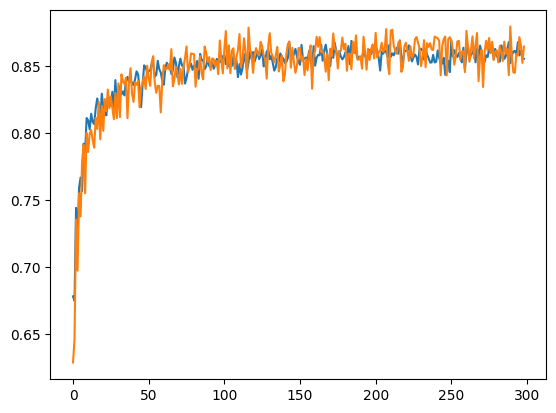

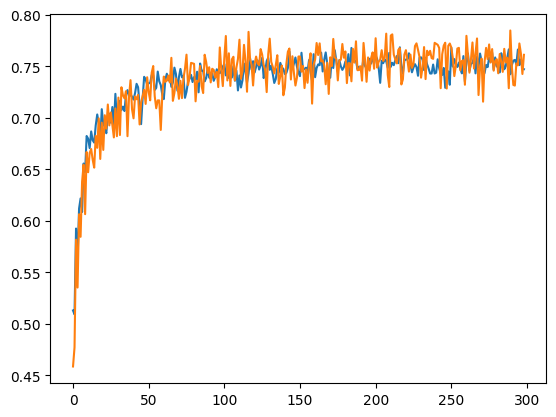

0.8689568638801575


In [11]:
model.eval()

val_f1 = [x[0] for x in val_losses]
val_iou = [x[1] for x in val_losses]

train_f1 = [x[0] for x in train_losses]
train_iou = [x[1] for x in train_losses]

# plot val_losses, train_losses on the same plot
plt.plot(val_f1[1:]) # azul
plt.plot(train_f1[1:]) # laranja
plt.show()

plt.plot(val_iou[1:]) # azul
plt.plot(train_iou[1:]) # laranja
plt.show()

print(max(val_f1))

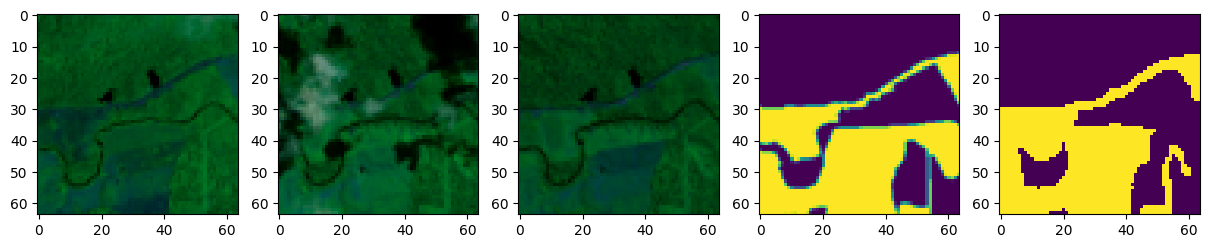

In [29]:
plot_images()